**Chosen Model: Random Forest Classifier** 

Random forest algorithm parameters:

n_estimators: The number of trees in the forest.  

criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.  
 
min_samples_split: The minimum number of samples required to split an internal node.  

min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.  

min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.  

max_features: The number of features to consider when looking for the best split.  

max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.  

min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.  

min_impurity_split: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.  

bootstrap: Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.  

oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# load csv file

fraud_df = pd.read_csv('../data/fraud_cleaned.csv')

In [3]:
fraud_size_df = fraud_df.sample(n=10000)

<Axes: xlabel='isFraud', ylabel='count'>

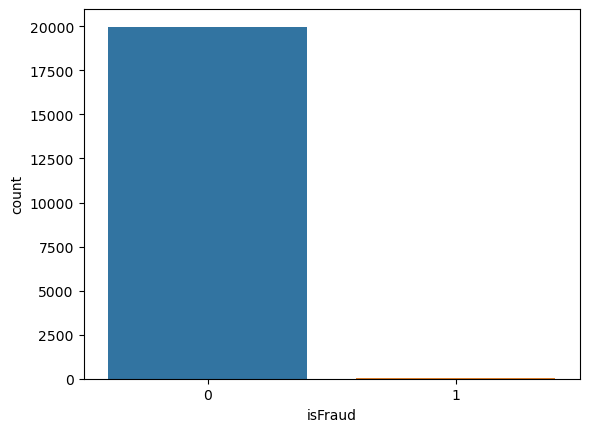

In [4]:
sns.countplot(x='isFraud', data=fraud_df)

In [5]:
fraud_df_encoded = pd.get_dummies(fraud_size_df, columns=['type'], prefix='type')

In [6]:
#create train test splits

# Create a 'X' and 'Y' training set, where 'X' is simply the dataframe without the 'isFraud' column
X = fraud_df_encoded.drop('isFraud', axis=1)

# and 'Y' is the 'isFraud' column
y = fraud_df_encoded['isFraud']

# create 'train_test_split' splits on the X and Y data where the test_size is 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# create a `print_score` method to generate a report
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [8]:
# create a 'RandomForestClassifier' 

rf_clf = RandomForestClassifier(n_estimators=100)

# fit the randomforest object using the X_train & y_train data
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [9]:
# generate a report on the random forest model

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0    1  accuracy  macro avg  weighted avg
precision     1.0  1.0       1.0        1.0           1.0
recall        1.0  1.0       1.0        1.0           1.0
f1-score      1.0  1.0       1.0        1.0           1.0
support    6992.0  8.0       1.0     7000.0        7000.0
_______________________________________________
Confusion Matrix: 
 [[6992    0]
 [   0    8]]

Test Result:
Accuracy Score: 99.90%
_______________________________________________
CLASSIFICATION REPORT:
                     0         1  accuracy    macro avg  weighted avg
precision     0.998999  1.000000     0.999     0.999500      0.999001
recall        1.000000  0.400000     0.999     0.700000      0.999000
f1-score      0.999499  0.571429     0.999     0.785464      0.998786
support    2995.000000  5.000000     0.999  3000.000000   3000.000000
_______________________________________________


**Chosen Hyperparameter Tuning: RandomSearchCV**

In [11]:
# search for the best possible hyperparameters, using RandomSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)
# Implement `RandomizedSearchCV` object
rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='f1',
    param_distributions=random_grid, 
    n_iter=200, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/nasehacho/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
460 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nasehacho/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nasehacho/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/nasehacho/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constrai

Best paramters: {'n_estimators': 822, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False})


Hyperparameter tuning output: Best paramters: 'n_estimators': 822, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False

Meaning:
'n_estimators': 822: Refers to the number of trees in the Random Forest ensemble. 822 decision trees will be used in the ensemble model.

'min_samples_split': 5: The minimum number of samples required to split an internal node. A node will only be split if it contains at least 5 samples.

'min_samples_leaf': 1: The minimum number of samples required to be at a leaf node. Each leaf node must contain at least 1 sample.

'max_features': 'sqrt': The maximum number of features to consider when looking for the best split. The square root of the total number of features will be used.

'max_depth': 70: The maximum depth of the trees in the Random Forest. No tree is allowed to have a depth greater than 70.

'bootstrap': False: Specifies whether bootstrap samples are used when building trees. In this case, bootstrap samples are not used, meaning that each tree in the ensemble is built using the entire dataset.

In [12]:
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0    1  accuracy  macro avg  weighted avg
precision     1.0  1.0       1.0        1.0           1.0
recall        1.0  1.0       1.0        1.0           1.0
f1-score      1.0  1.0       1.0        1.0           1.0
support    6992.0  8.0       1.0     7000.0        7000.0
_______________________________________________
Confusion Matrix: 
 [[6992    0]
 [   0    8]]

Test Result:
Accuracy Score: 99.90%
_______________________________________________
CLASSIFICATION REPORT:
                     0         1  accuracy    macro avg  weighted avg
precision     0.998999  1.000000     0.999     0.999500      0.999001
recall        1.000000  0.400000     0.999     0.700000      0.999000
f1-score      0.999499  0.571429     0.999     0.785464      0.998786
support    2995.000000  5.000000     0.999  3000.000000   3000.000000
_______________________________________________
